# Imports and Data

In [79]:
from typing import NamedTuple
import pandas as pd
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import lru_cache


class CollegeMessage(NamedTuple):
    source: int  #source id
    target: int  # target id
    unix_timestamp: int  # seconds after last epoc


def read_message_data(datapath: str) -> list[CollegeMessage]:
    filepath = Path.cwd() / Path(datapath)

    if not filepath.exists():
        raise FileNotFoundError(
            f"File not found: {filepath}; " +
            f"Current working directory: {Path.cwd()}; " +
            f"Relative path to data file: {Path(datapath)}"
        )

    print(f"Using file: {filepath.absolute()}")

    messages = []
    with open(filepath, 'r', encoding="UTF-8") as f:
        for line in f:
            source, target, timestamp = line.strip().split()
            messages.append(CollegeMessage(int(source), int(target), int(timestamp)))
    print("done")
    return messages


def remove_low_degree_nodes(data: pd.DataFrame, min_degree: int) -> pd.DataFrame:
    in_degree = data['target'].value_counts()
    out_degree = data['source'].value_counts()
    high_degree_nodes = set(in_degree[in_degree >= min_degree].index) & set(out_degree[out_degree >= min_degree].index)
    return data[data['source'].isin(high_degree_nodes) & data['target'].isin(high_degree_nodes)]


def create_graph(data: pd.DataFrame) -> nx.DiGraph:
    digraph = nx.DiGraph()

    for row in data.itertuples(index=False):
        digraph.add_edge(row.source, row.target, timestamp=row.unix_timestamp)

    return digraph


def graph_figure(graph: nx.DiGraph):
    pos = nx.arf_layout(graph)
    nx.draw(graph, pos, with_labels=False, node_size=10)


# Layout calculations, cached by LRU to avoid recalculating the layout
@lru_cache(maxsize=None)
def cache_layout(graph: nx.DiGraph, layout_func: callable):
    print("Calculating layout ...")
    layout = layout_func(graph)
    print("... done calculating layout")
    return layout

In [80]:
_DATA_PATH = "./dataset/CollegeMsg.txt"

_MESSAGES = read_message_data(_DATA_PATH)

DF_MESSAGES = remove_low_degree_nodes(pd.DataFrame(_MESSAGES), 2)

GRAPH_MESSAGES = create_graph(DF_MESSAGES)

Using file: /home/mojmir-majer/projects/private/github/rug-sna-pizza-giving/college_msg_files/dataset/CollegeMsg.txt
done


In [81]:
DF_MESSAGES.head()

,source,target,unix_timestamp
39,41,42,1082574211
48,36,50,1082597715
49,44,51,1082597751
50,32,52,1082598056
51,36,32,1082598122


# Time window

In [92]:
def time_window(graph: nx.DiGraph, unix_start: int, unix_end: int) -> nx.DiGraph:
    return graph.edge_subgraph([
        (source, target)
        for source, target, timestamp in graph.edges(data='timestamp')
        if unix_start <= timestamp <= unix_end
    ])


import networkx as nx
from pathlib import Path
from matplotlib.colors import Normalize
import matplotlib.cm as cm


def export_graph(
        graph: nx.DiGraph,
        pos: dict,
        export_path: Path = None,
        fig_size=(10, 10),
        base_node_size=50,
        node_size_factor=20,
        edge_alpha=0.3,
        node_color_map='viridis',  # Choose your desired colormap
        default_node_color='lightgray',  # Color for nodes with zero messages
        edge_color='gray',
        dpi=300
):
    """
    Exports a NetworkX graph to an image file with consistent styling and a colormap based on node message counts.

    Parameters:
    - graph (nx.DiGraph): The directed graph to export.
    - pos (dict): A dictionary specifying node positions.
    - export_path (Path, optional): Path to save the exported image. If None, the image is not saved.
    - fig_size (tuple, optional): Size of the figure in inches. Defaults to (10, 10).
    - base_node_size (int, optional): Base size for nodes. Defaults to 100.
    - node_size_factor (int, optional): Factor to scale node sizes based on degree. Defaults to 20.
    - edge_alpha (float, optional): Transparency level for edges (0 to 1). Defaults to 0.3.
    - node_color_map (str, optional): Matplotlib colormap name for node colors. Defaults to 'viridis'.
    - default_node_color (str, optional): Color for nodes with zero messages. Defaults to 'lightgray'.
    - edge_color (str or list, optional): Color of the edges. Defaults to 'gray'.
    - dpi (int, optional): Dots per inch for the saved image. Defaults to 300.
    """

    # Create a new figure with the specified size
    plt.figure(figsize=fig_size)

    # Calculate the total degree (in-degree + out-degree) for each node
    degrees = {node: graph.in_degree(node) + graph.out_degree(node) for node in graph.nodes()}

    # Scale node sizes based on their degrees
    node_sizes = [base_node_size + degrees[node] * node_size_factor for node in graph.nodes()]

    # Prepare color mapping based on degrees
    # Nodes with degree > 0 will be colored based on the colormap
    # Nodes with degree == 0 will have the default color

    # Extract degrees for nodes with degree > 0
    non_zero_degrees = [deg for deg in degrees.values() if deg > 0]

    if non_zero_degrees:
        norm = Normalize(vmin=min(non_zero_degrees), vmax=max(non_zero_degrees))
        cmap = cm.get_cmap(node_color_map)
        node_colors = [
            cmap(norm(degrees[node])) if degrees[node] > 0 else default_node_color
            for node in graph.nodes()
        ]
    else:
        # If all nodes have zero degree, assign the default color
        node_colors = [default_node_color for _ in graph.nodes()]

    # Draw edges with specified transparency
    nx.draw_networkx_edges(
        graph,
        pos,
        alpha=edge_alpha,
        edge_color=edge_color,
        arrows=True,  # To show direction in DiGraph
        arrowstyle='->',
        arrowsize=10,
        connectionstyle='arc3,rad=0.1'  # Slight curvature for better visibility
    )

    # Draw nodes with scaled sizes and color mapping
    nx.draw_networkx_nodes(
        graph,
        pos,
        node_size=node_sizes,
        node_color=node_colors,
        # edgecolors='black',  # Optional: Add border to nodes
        linewidths=0.5
    )

    # Optional: Remove axes for a cleaner look
    plt.axis('off')

    # Adjust layout to ensure everything fits without clipping
    plt.tight_layout()

    # Save the figure if an export path is provided
    if export_path:
        # Ensure the parent directory exists
        export_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(export_path, bbox_inches='tight', dpi=dpi)

    # Close the figure to free up memory
    plt.close()


def export_time_windows(pos: dict):
    # Define the base export directory
    export_base = Path("./.export")
    export_base.mkdir(exist_ok=True)  # Create the directory if it doesn't exist

    # Find all existing subdirectories with two-digit numeric names
    existing_folders = [
        folder for folder in export_base.iterdir()
        if folder.is_dir() and folder.name.isdigit() and len(folder.name) == 2
    ]

    if existing_folders:
        # Extract the numerical part from folder names and find the maximum
        max_num = max(int(folder.name) for folder in existing_folders)
    else:
        # If no such folders exist, start with -1 so the first folder will be '00'
        max_num = -1

    # Determine the name of the next folder (e.g., '00', '01', ...)
    next_num = max_num + 1
    new_folder_name = f"{next_num:02}"  # Zero-padded to two digits
    new_folder = export_base / new_folder_name
    new_folder.mkdir()  # Create the new export folder

    print(f"Exporting graphs to folder: {new_folder}")

    start_unix_timestamp = DF_MESSAGES['unix_timestamp'].min()
    end_unix_timestamp = DF_MESSAGES['unix_timestamp'].max()

    # todo all days
    # start_datetime = pd.to_datetime(start_unix_timestamp)
    # end_datetime = pd.to_datetime(end_unix_timestamp)
    # days = (start_datetime - end_datetime).days
    total = 14

    day_in_seconds = 60 * 60 * 24

    # Generate timeframes for each day
    timeframes = (
        start_unix_timestamp + day_in_seconds * i
        for i in range(total)  # Changed from range(0, total) to range(total) for clarity
    )

    # Generate subgraphs for each timeframe
    subgraphs = (
        time_window(GRAPH_MESSAGES, timeframe, timeframe + day_in_seconds)
        for timeframe in timeframes
    )

    # Iterate over each subgraph and export the corresponding graph image
    for i, graph in tqdm(enumerate(subgraphs), total=total, desc="Exporting graphs"):
        export_path = new_folder / f"graph_{i:02}.png"  # Zero-padded image names
        export_graph(graph, pos, export_path)

    print(f"All graphs have been exported to {new_folder}")

In [93]:
export_time_windows(cache_layout(GRAPH_MESSAGES, nx.arf_layout))

Exporting graphs to folder: .export/08


Exporting graphs: 100%|██████████| 14/14 [00:30<00:00,  2.21s/it]

All graphs have been exported to .export/08


In [94]:
def export_graph_undirected(
        graph: nx.Graph,
        pos: dict,
        export_path: Path = None,
        fig_size=(10, 10),
        base_node_size=50,
        node_size_factor=20,
        edge_alpha=0.6,
        edge_color='gray',
        node_color_map='viridis',  # Choose your desired colormap
        default_node_color='lightgray',  # Color for nodes with zero messages
        dpi=300
):
    """
    Exports a NetworkX undirected graph to an image file with consistent styling,
    edge widths based on message counts, and a colormap for node intensities.

    Parameters:
    - graph (nx.Graph): The undirected graph to export with 'weight' on edges.
    - pos (dict): A dictionary specifying node positions.
    - export_path (Path, optional): Path to save the exported image. If None, the image is not saved.
    - fig_size (tuple, optional): Size of the figure in inches. Defaults to (10, 10).
    - base_node_size (int, optional): Base size for nodes. Defaults to 100.
    - node_size_factor (int, optional): Factor to scale node sizes based on degree. Defaults to 20.
    - edge_alpha (float, optional): Transparency level for edges (0 to 1). Defaults to 0.6.
    - edge_color (str or list, optional): Color of the edges. Defaults to 'gray'.
    - node_color_map (str, optional): Matplotlib colormap name for node colors. Defaults to 'viridis'.
    - default_node_color (str, optional): Color for nodes with zero messages. Defaults to 'lightgray'.
    - dpi (int, optional): Dots per inch for the saved image. Defaults to 300.
    """

    # Create a new figure with the specified size
    plt.figure(figsize=fig_size)

    # Calculate the total degree (in-degree + out-degree) for each node
    # Since the graph is undirected, use graph.degree()
    degrees = dict(graph.degree())

    # Scale node sizes based on their degrees
    node_sizes = [base_node_size + degrees[node] * node_size_factor for node in graph.nodes()]

    # Prepare color mapping based on degrees
    # Nodes with degree > 0 will be colored based on the colormap
    # Nodes with degree == 0 will have the default color

    # Extract degrees for nodes with degree > 0
    non_zero_degrees = [deg for deg in degrees.values() if deg > 0]

    if non_zero_degrees:
        norm = Normalize(vmin=min(non_zero_degrees), vmax=max(non_zero_degrees))
        cmap = cm.get_cmap(node_color_map)
        node_colors = [
            cmap(norm(degrees[node])) if degrees[node] > 0 else default_node_color
            for node in graph.nodes()
        ]
    else:
        # If all nodes have zero degree, assign the default color
        node_colors = [default_node_color for _ in graph.nodes()]

    # Prepare edge widths based on 'weight'
    edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]
    if edge_weights:
        # Normalize edge widths for better visualization
        max_weight = max(edge_weights)
        min_weight = min(edge_weights)
        # Define minimum and maximum edge widths
        min_width = 0.5
        max_width = 5
        # Avoid division by zero
        if max_weight == min_weight:
            edge_widths = [(max_width + min_width) / 2 for _ in edge_weights]
        else:
            edge_widths = [
                min_width + (weight - min_weight) / (max_weight - min_weight) * (max_width - min_width)
                for weight in edge_weights
            ]
    else:
        edge_widths = []

    # Draw edges with specified transparency and widths
    nx.draw_networkx_edges(
        graph,
        pos,
        alpha=edge_alpha,
        edge_color=edge_color,
        width=edge_widths
    )

    # Draw nodes with scaled sizes and color mapping
    nx.draw_networkx_nodes(
        graph,
        pos,
        node_size=node_sizes,
        node_color=node_colors,
        # Optional: Add border to nodes
        # edgecolors='black',  
        linewidths=0.5
    )

    # Optional: Remove axes for a cleaner look
    plt.axis('off')

    # Adjust layout to ensure everything fits without clipping
    plt.tight_layout()

    # Save the figure if an export path is provided
    if export_path:
        # Ensure the parent directory exists
        export_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(export_path, bbox_inches='tight', dpi=dpi)

    # Close the figure to free up memory
    plt.close()


def time_window_undirected(graph: nx.DiGraph, unix_start: int, unix_end: int) -> nx.Graph:
    """
    Extracts a subgraph within the specified time window, treating edges as undirected
    and aggregating the number of messages between node pairs.

    Parameters:
    - graph (nx.DiGraph): The original directed graph with 'timestamp' on edges.
    - unix_start (int): Start of the time window (inclusive).
    - unix_end (int): End of the time window (inclusive).

    Returns:
    - nx.Graph: An undirected graph with 'weight' attributes on edges.
    """
    # Filter edges within the time window
    filtered_edges = [
        (min(source, target), max(source, target))  # Ensure consistent ordering
        for source, target, timestamp in graph.edges(data='timestamp')
        if unix_start <= timestamp <= unix_end
    ]

    # Aggregate message counts between node pairs
    edge_weights = {}
    for src, dest in filtered_edges:
        if (src, dest) in edge_weights:
            edge_weights[(src, dest)] += 1
        else:
            edge_weights[(src, dest)] = 1

    # Create an undirected graph
    undirected_graph = nx.Graph()
    undirected_graph.add_nodes_from(graph.nodes(data=True))  # Preserve node attributes if any

    # Add edges with 'weight' attribute
    for (src, dest), weight in edge_weights.items():
        undirected_graph.add_edge(src, dest, weight=weight)

    return undirected_graph


from pathlib import Path
from tqdm import tqdm
import math


def export_time_windows_undirected(pos: dict):
    """
    Exports graph visualizations for each time window into uniquely numbered folders.
    Each graph is undirected with edge widths based on message counts.

    Parameters:
    - pos (dict): A dictionary specifying node positions.
    """
    start_unix_timestamp = DF_MESSAGES['unix_timestamp'].min()
    end_unix_timestamp = DF_MESSAGES['unix_timestamp'].max()

    # Calculate the total number of days dynamically
    day_in_seconds = 60 * 60 * 24
    total_seconds = end_unix_timestamp - start_unix_timestamp
    # total_days = math.ceil(total_seconds / day_in_seconds)
    total_days = 14

    # Generate timeframes for each day
    timeframes = (
        start_unix_timestamp + day_in_seconds * i
        for i in range(total_days)
    )

    # Generate subgraphs for each timeframe
    subgraphs = (
        time_window_undirected(GRAPH_MESSAGES, timeframe, timeframe + day_in_seconds)
        for timeframe in timeframes
    )

    # Determine the next export folder using pathlib
    export_base = Path("./.export")
    export_base.mkdir(exist_ok=True)  # Create the directory if it doesn't exist

    # Find all existing subdirectories with two-digit numeric names
    existing_folders = [
        folder for folder in export_base.iterdir()
        if folder.is_dir() and folder.name.isdigit() and len(folder.name) == 2
    ]

    if existing_folders:
        # Extract the numerical part from folder names and find the maximum
        max_num = max(int(folder.name) for folder in existing_folders)
    else:
        # If no such folders exist, start with -1 so the first folder will be '00'
        max_num = -1

    # Determine the name of the next folder (e.g., '00', '01', ...)
    next_num = max_num + 1
    new_folder_name = f"{next_num:02}"  # Zero-padded to two digits
    new_folder = export_base / new_folder_name
    new_folder.mkdir()  # Create the new export folder

    print(f"Exporting graphs to folder: {new_folder}")

    # Iterate over each subgraph and export the corresponding graph image
    for i, graph in tqdm(enumerate(subgraphs), total=total_days, desc="Exporting graphs"):
        export_path = new_folder / f"graph_{i:02}.png"
        export_graph_undirected(
            graph,
            pos,
            export_path,
            node_color_map='plasma',  # Example: change colormap if desired
            default_node_color='lightgray'
        )

    print(f"All graphs have been exported to {new_folder}")

Exporting graphs to folder: .export/09


Exporting graphs:  39%|███▉      | 73/188 [01:23<02:11,  1.14s/it]

KeyboardInterrupt



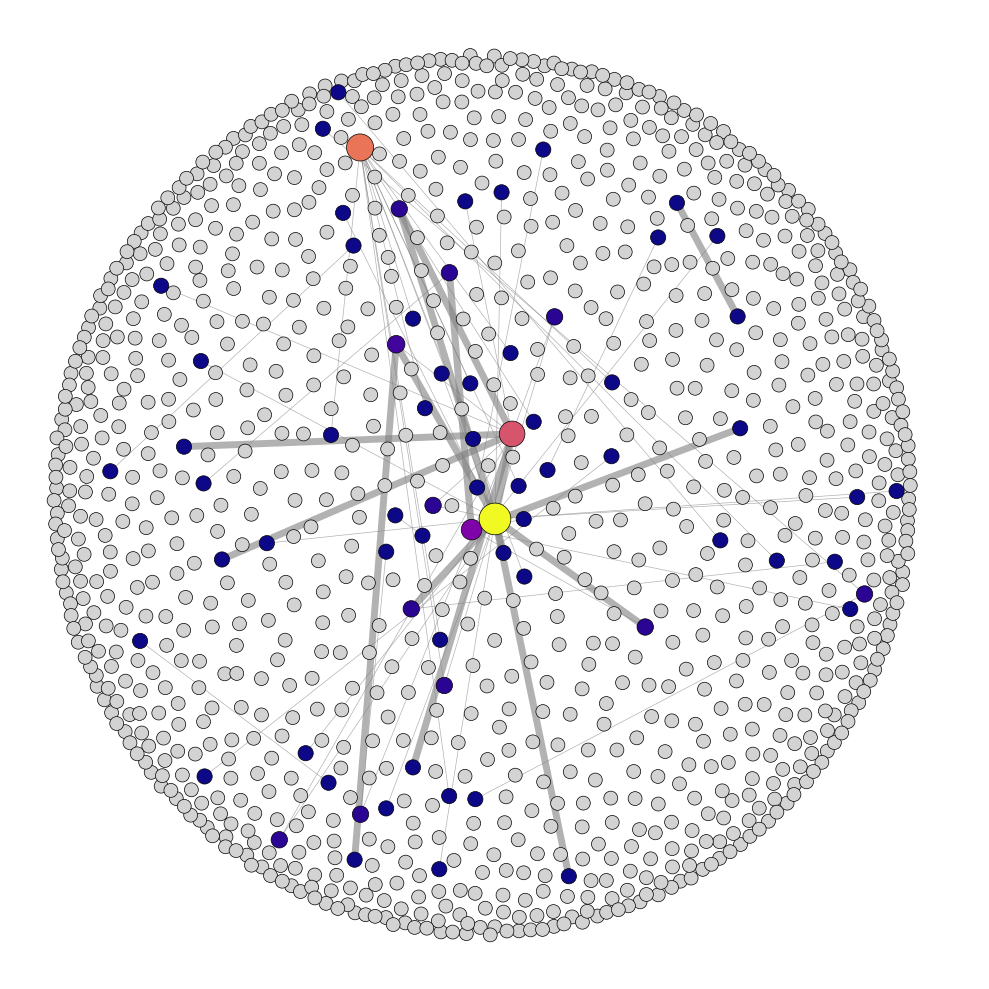

In [95]:
export_time_windows_undirected(cache_layout(GRAPH_MESSAGES, nx.arf_layout))